In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy import sin,cos,pi
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
# plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

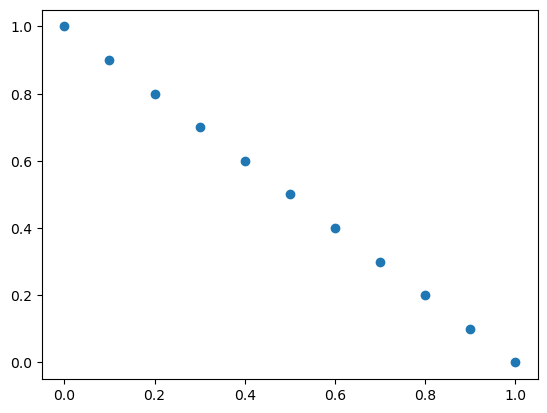

In [2]:
# 直线拟合
xx = np.arange(0,1.1,0.1)
yy = -1 * xx + 1
plt.scatter(xx,yy)
plt.show()


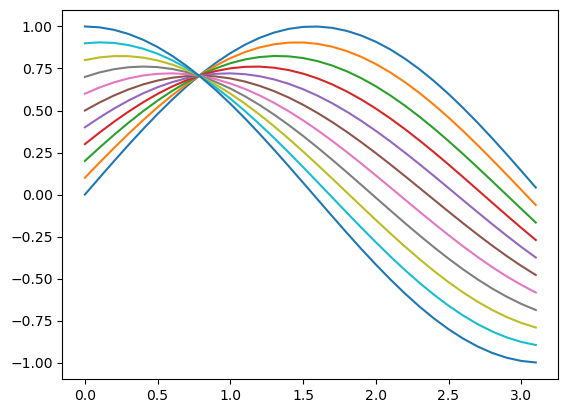

In [3]:
points = [(xx[i],yy[i]) for i in range(len(xx))]

theta = np.arange(0,pi,0.1)
for point in points:
    x,y = point
    rho = x * cos(theta) + y * sin(theta)
    plt.plot(theta,rho)
plt.show()

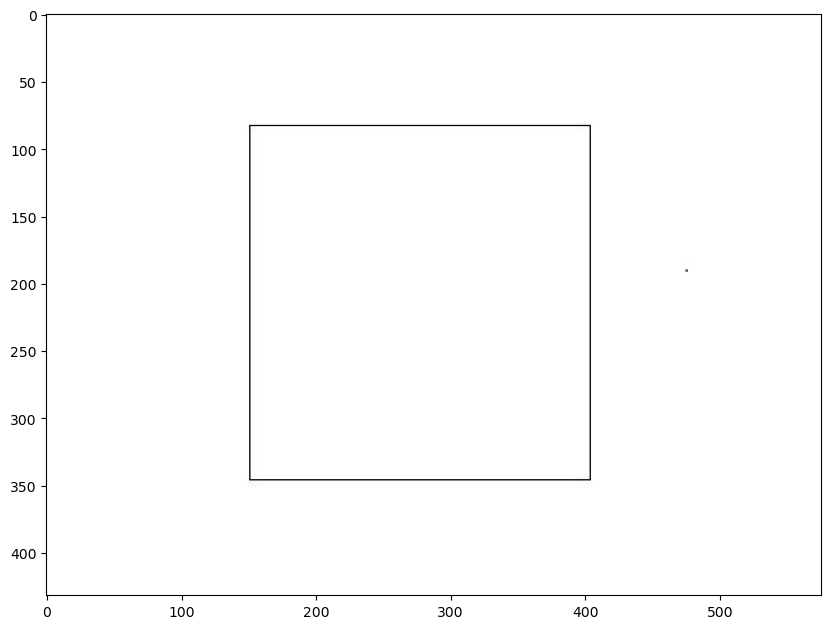

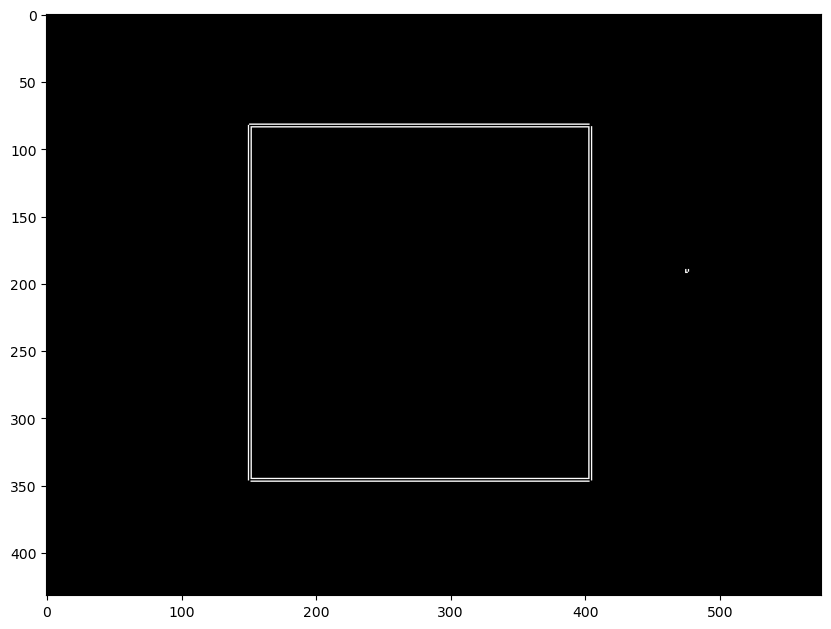

In [4]:
image = cv2.imread("./image/hough_4.jpg")
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_gray,cv2.COLOR_GRAY2RGB))
plt.show()
edges = cv2.Canny(image_gray, threshold1=100, threshold2=100)
edges_show = cv2.cvtColor(edges,cv2.COLOR_GRAY2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(edges_show)
plt.show()


In [5]:
height,width = edges.shape
half_width = int(width/2)
half_height = int(height/2)
max_p = int(0.5 + np.sqrt(half_height**2+half_width**2))


H = np.zeros((181,2 * max_p))
for y,rows in enumerate(edges):
    for x,value in enumerate(rows):
        if value <= 0:
            continue
        x_t = x - half_width
        y_t = y - half_height
        for theta in np.arange(0,181,1):
            p = x_t * cos(theta*pi/180) + y_t * sin(theta*pi/180)
            H[theta,int(p) + max_p] += 1
        pass
p_image = np.array(H/H.max() * 255,dtype=np.uint8)

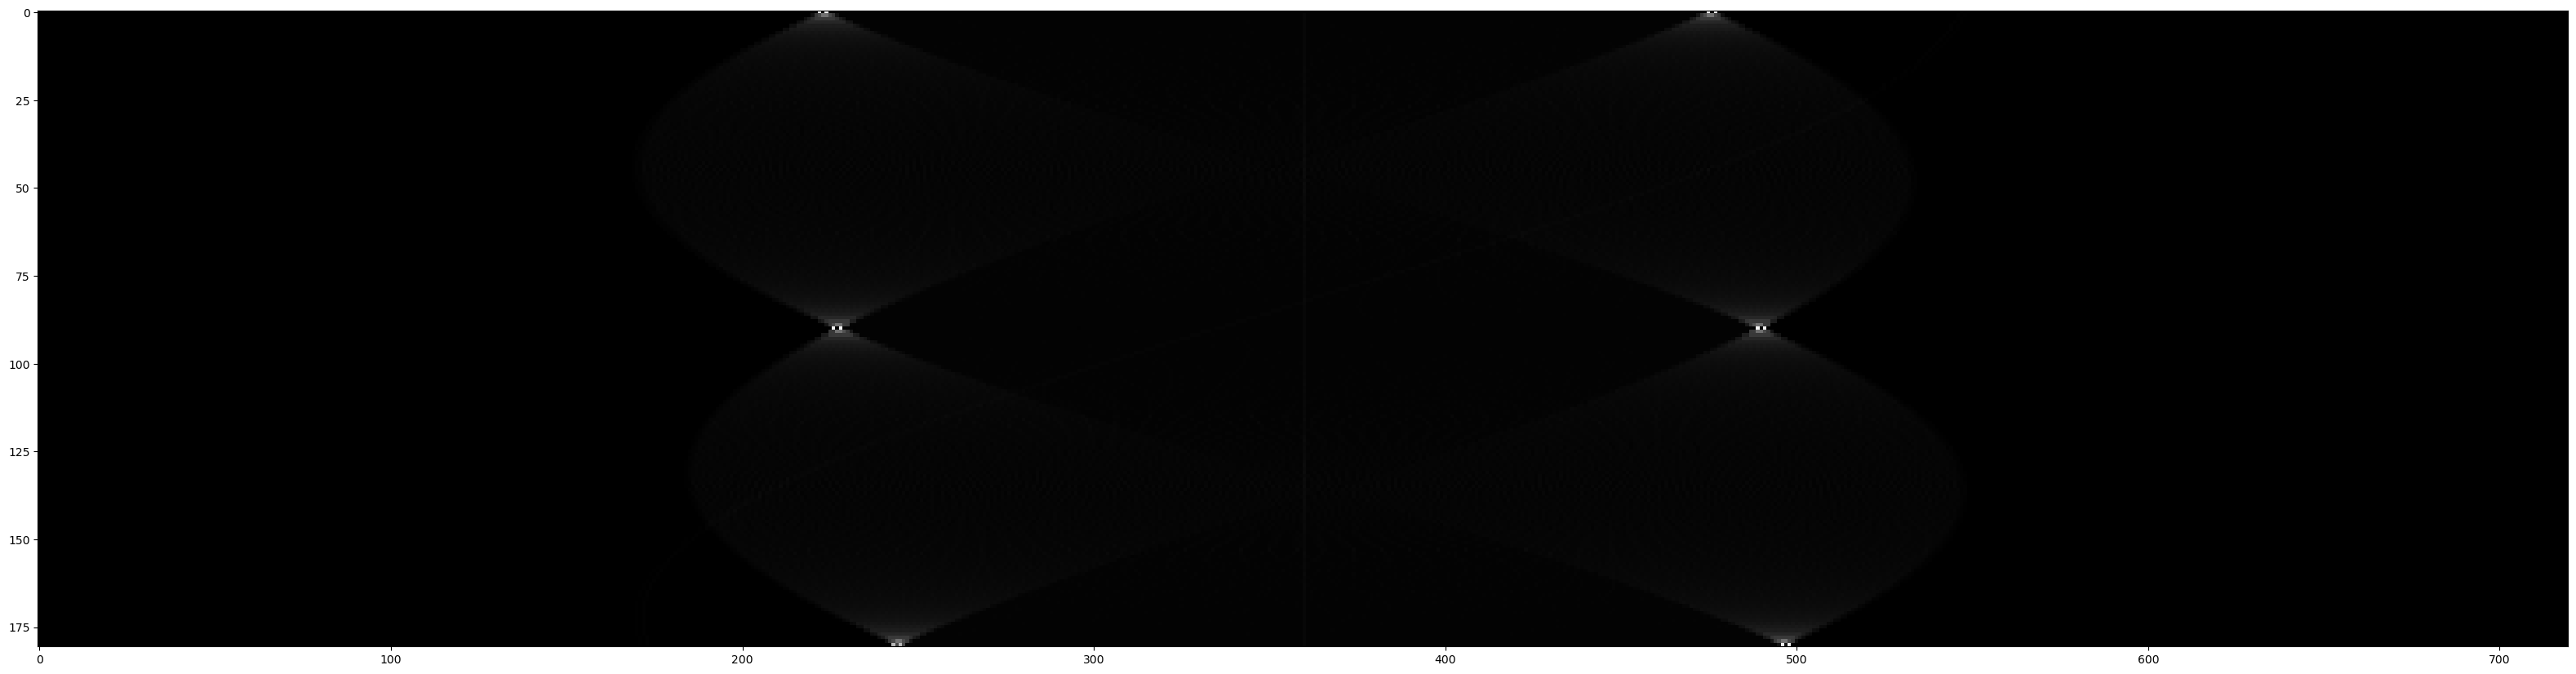

In [6]:
plt.figure(figsize=(40,40))
plt.imshow(cv2.cvtColor(p_image,cv2.COLOR_GRAY2RGB))

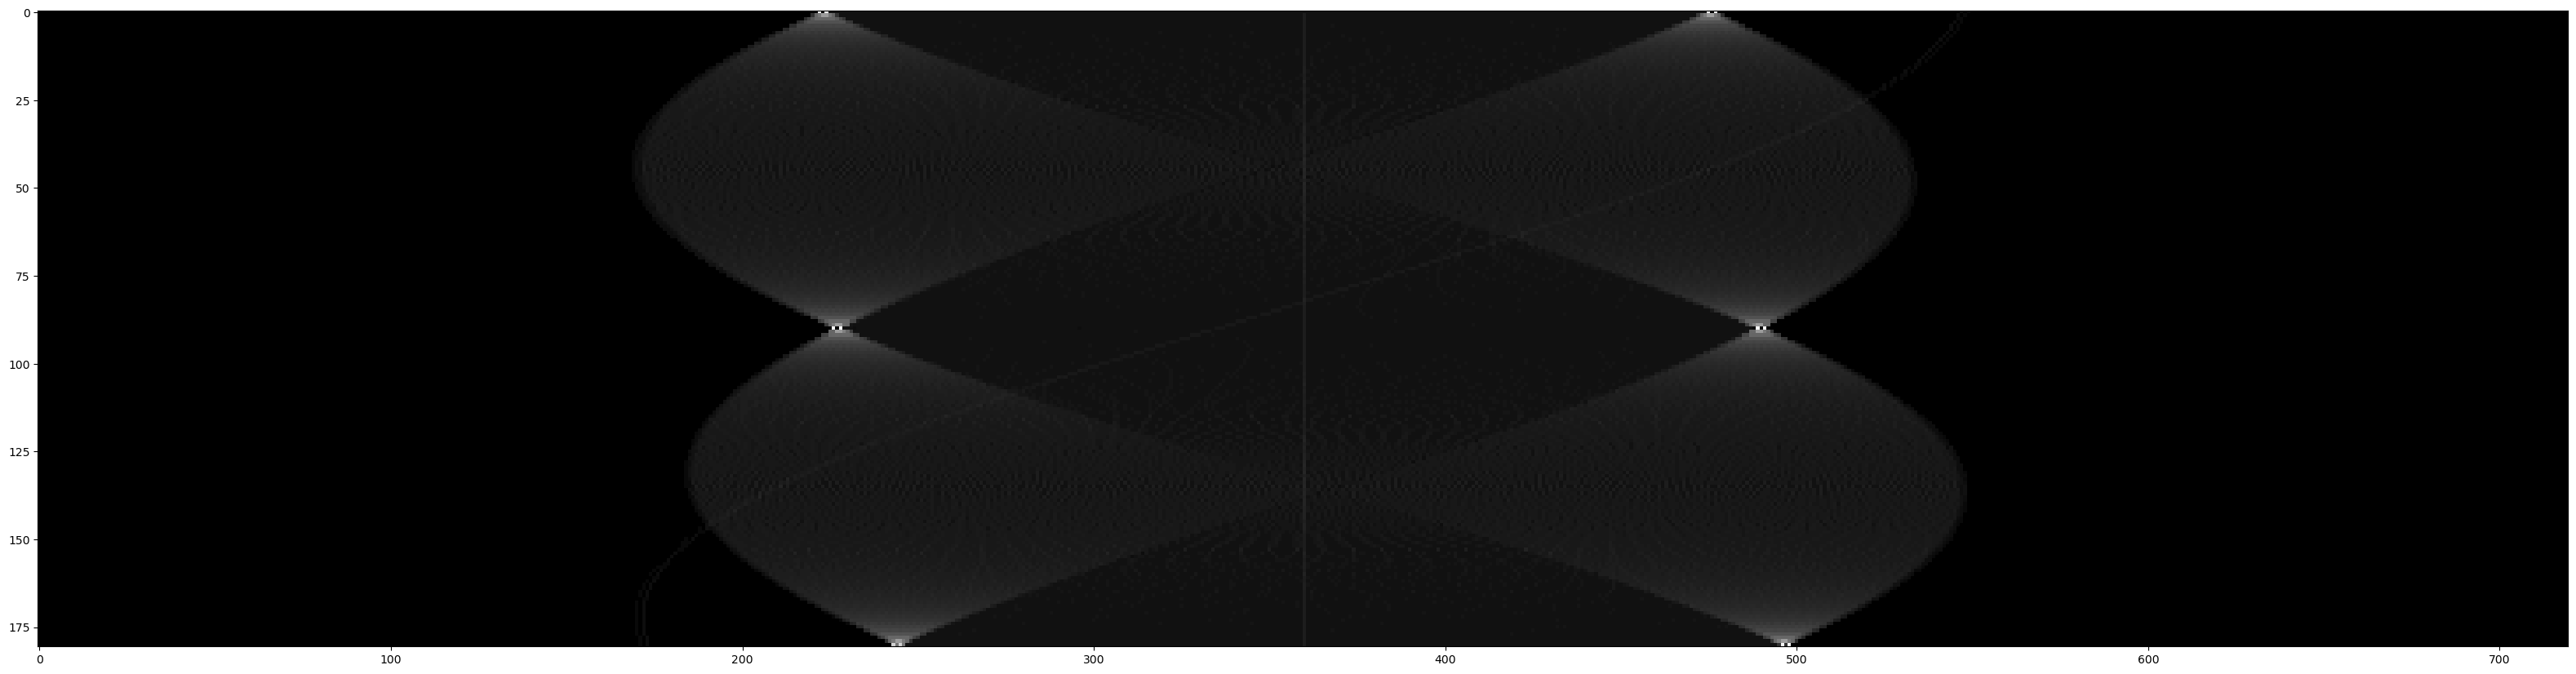

In [7]:
# gamma 
plt.figure(figsize=(40,40))
temp = np.power(p_image/255,0.6)*255
temp = np.array(temp,np.uint8)
plt.imshow(cv2.cvtColor(temp,cv2.COLOR_GRAY2RGB))
# cv2.imshow("ff",cv2.cvtColor(temp,cv2.COLOR_GRAY2RGB))
# cv2.waitKey(0)

In [8]:
# 直方图均匀化
# plt.figure(figsize=(40,40))
# plt.imshow(cv2.cvtColor(cv2.equalizeHist(p_image),cv2.COLOR_GRAY2RGB))

In [9]:
# 搜索峰值
def detect_peaks(data, min_value,n_size=3):
    height,width = data.shape
    peaks_list = list()
    for row, rows in enumerate(data):
        for col,cell in enumerate(rows):
            # 取邻域
            if row == 0 : continue
            neighborhood = list()
            half_size = int(n_size/2)
            for i in range(n_size):
                for j in range(n_size):
                    if i == half_size and j == half_size : continue
                    x = col - half_size + j
                    y = row - half_size + i
                    neighborhood.append(data[y,x] if x > 0 and x < width and y > 0 and y < height else 0)
            m = np.array(neighborhood).max()
            if m < data[row,col] and cell >= min_value:
                peaks_list.append((row,col,cell))
    return peaks_list
peaks = detect_peaks(p_image,60,3)
peaks.sort(key=lambda a: a[2], reverse=True)
peaks = np.array(peaks)
peaks = peaks[:20,:]
peaks


array([[ 90, 228, 245],
       [ 90, 489, 245],
       [ 90, 226, 244],
       [ 90, 491, 243],
       [180, 496, 239],
       [180, 498, 238],
       [180, 245, 185],
       [180, 243, 184],
       [  1, 223, 113],
       [  1, 476, 113]])

In [10]:
Theta = peaks[:, 0]
P = peaks[:, 1] - max_p
X = list()
Y = list()
for i in range(P.shape[0]):
    # 两点式
    if Theta[i] == 0:
        x = np.array([P[i],P[i]])
        y = np.array([-half_height, half_height])
    elif Theta[i] == 180:
        x = np.array([-P[i], -P[i]])
        y = np.array([-half_height, half_height])
    else:
        x = np.array([-half_width, half_width])
        y = (P[i] - x * np.cos(Theta[i]*pi/180))/np.sin(Theta[i]*pi/180)

    X.append(x)
    Y.append(y)
X = np.array(X,np.int32) + half_width
Y = np.array(Y, np.int32) + half_height


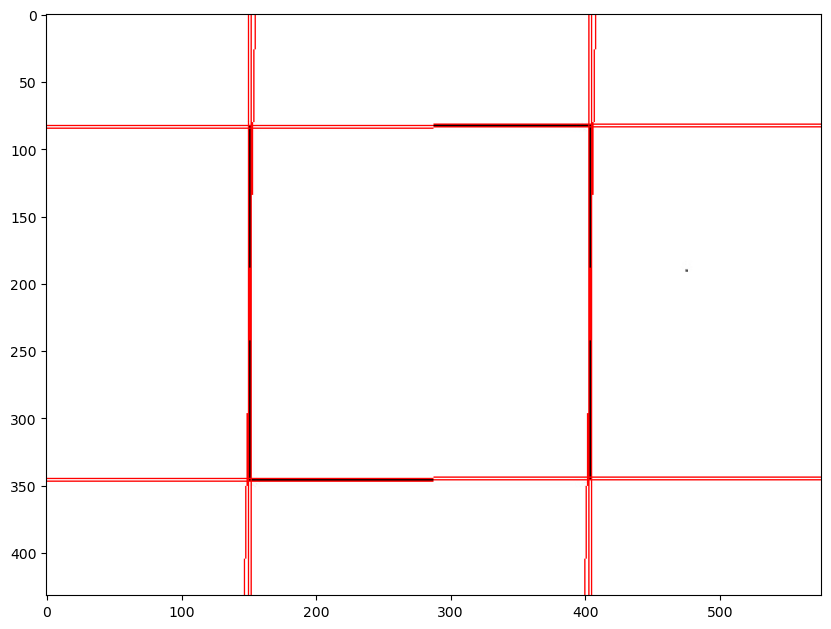

In [11]:
image_copy = image.copy()

for i in range(X.shape[0]):
    cv2.line(image_copy,(X[i][0],Y[i][0]),(X[i][1],Y[i][1]),(0,0,255))
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_copy,cv2.COLOR_BGR2RGB))

[[[480.5 614.5  53. ]
  [251.5 189.5  53. ]
  [192.5 732.5  79.4]
  [274.5 463.5  39.7]]]


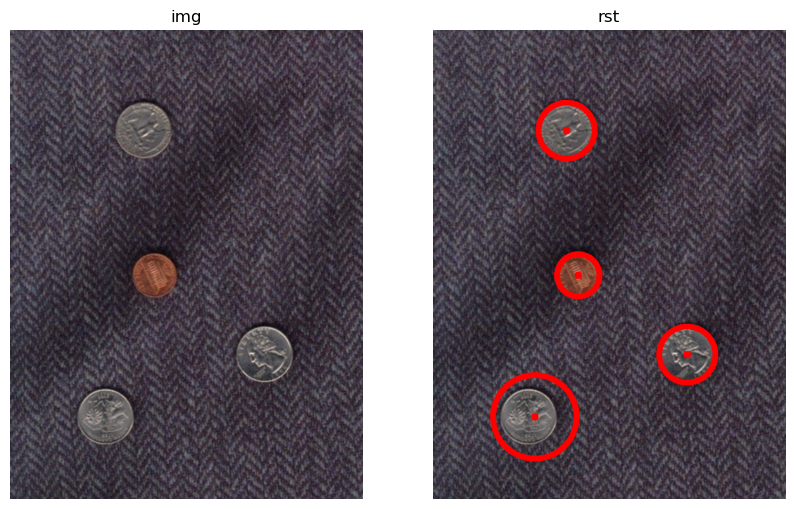

In [12]:
# 检测圆

image = cv2.imread("./image/hough_7.jpg")
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
new_img = rgb_img.copy()

circles = cv2.HoughCircles(gray_img, cv2.HOUGH_GRADIENT, 1,
                           200, param1=120, param2=55, minRadius=30, maxRadius=80)
print(circles)
circles = np.uint16(np.around(circles))
for i in circles[0, :]:
    cv2.circle(new_img, (i[0], i[1]), i[2], (255, 0, 0), 10)
    # 圆心
    cv2.circle(new_img, (i[0], i[1]), 2, (255, 0, 0), 10)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(rgb_img)
plt.title('img')
plt.axis('off')

plt.subplot(122)
plt.imshow(new_img)
plt.title('rst')
plt.axis('off')
plt.show()


In [13]:
circles


array([[[480, 614,  53],
        [252, 190,  53],
        [192, 732,  79],
        [274, 464,  40]]], dtype=uint16)